# harm_take2
## Purpose: Learn how to use the aneris tool for harmonization
Struggling with aneris... take 2 based on Smith script
- Historical (1750-2022) and projected (2020-2100) emissions datasets
    - Historical dataset is product of PRIMAP, CEDS, GCP, & GFED
    - Projected datasets are outputs of GCAM 6.0 NGFS and MESSAGEix-GLOBIOM (will focus on one at a time)
    
    
Credit: 
- Gidden, M. (2017). gidden/aneris: Initial release version for harmonization paper (v0.1.0). Zenodo. https://doi.org/10.5281/ZENODO.802832
- https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


## Erica Simon, 02/02/24

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import aneris
import aneris.convenience
from tqdm.auto import tqdm

import datetime
import os
import warnings

## Import datasets

In [21]:
future = pd.read_csv('~/outputs/NGFS_GCAM_interp.csv')
hist = pd.read_csv('~/outputs/hist_emis_ALL.csv')

In [22]:
# Harmonization overrides - use same as RCMIP
overrides = pd.DataFrame(
    [
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C2F6",
        },  # high historical variance (cov=16.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C6F14",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CF4",
        },  # high historical variance (cov=11.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CO",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2080",
            "variable": "Emissions|CO2",
        },  # always ratio method by choice
        {
            "method": "reduce_offset_2150_cov",
            "variable": "Emissions|CO2|AFOLU",
        },  # high historical variance, but using offset method to prevent diff from
        # increasing when going negative rapidly (cov=23.2)
        {
            "method": "reduce_ratio_2080",  # always ratio method by choice
            "variable": "Emissions|CO2|Energy and Industrial Processes",
        },
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|CH4'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-125",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-134a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-143a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-227ea",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-23",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-32",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-4310mee",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|N2O'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NH3'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NOx'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|OC",
        },  # high historical variance (cov=18.5)
        {
            "method": "constant_ratio",
            "variable": "Emissions|SF6",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|Sulfur'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|VOC",
        },  # high historical variance (cov=12.0)
    ]
)

In [23]:
progress = os.getenv("PROGRESS", "False").lower() in ("true", "1", "t")

In [24]:
# this block of code adapted from from https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py

harmonisation_year = 2022

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scenarios_harmonised = [
        aneris.convenience.harmonise_all(
            msdf,
            history=hist,
            year=harmonisation_year,
            overrides=overrides,
        )
        for _, msdf in tqdm(future.groupby(["Model", "Scenario"]), disable=1 - progress)
    ]

scenarios_harmonised = pd.concat(scenarios_harmonised).reset_index()

INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing wit

In [25]:
scenarios_harmonised.head()

,model,scenario,region,variable,unit,2022,2023,2024,2025,2026,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,GCAM 6.0 NGFS,Below 2 C,World,Emissions|BC,Mt BC/yr,6.701702,6.514716,6.328371,6.142668,5.970416,...,1.908504,1.909592,1.910681,1.911769,1.912858,1.913896,1.914934,1.915973,1.917011,1.918049
1,GCAM 6.0 NGFS,Below 2 C,World,Emissions|C2F6,kt C2F6/yr,1.167145,1.187433,1.207783,1.228194,1.199387,...,0.908171,0.903291,0.898392,0.893474,0.888537,0.884270,0.879985,0.875684,0.871367,0.867032
2,GCAM 6.0 NGFS,Below 2 C,World,Emissions|CF4,kt CF4/yr,7.204285,7.318735,7.432465,7.545476,7.506468,...,2.193012,2.099410,2.006379,1.913919,1.822028,1.750974,1.680355,1.610170,1.540421,1.471106
3,GCAM 6.0 NGFS,Below 2 C,World,Emissions|CH4,Mt CH4/yr,378.405896,377.950220,377.491840,377.030757,370.793608,...,246.543212,246.884856,247.226500,247.568144,247.909788,248.005228,248.100668,248.196108,248.291548,248.386987
4,GCAM 6.0 NGFS,Below 2 C,World,Emissions|CO,Mt CO/yr,758.190637,740.025721,721.874130,703.735864,684.137844,...,319.248994,319.258361,319.267626,319.276792,319.285857,319.436284,319.586502,319.736512,319.886312,320.035904


## Visualize

In [26]:
ch4_hist = hist.loc[hist.Variable == 'Emissions|CH4'].values[0][255:]
ch4_raw = future.loc[future.Variable == 'Emissions|CH4'].loc[future.Scenario == 'Current Policies'].values[0][7:]
ch4_harm = scenarios_harmonised.loc[scenarios_harmonised.variable == 'Emissions|CH4'].loc[scenarios_harmonised.scenario == 'Current Policies'].values[0][5:]

In [27]:
mdl = scenarios_harmonised.model.values[0]

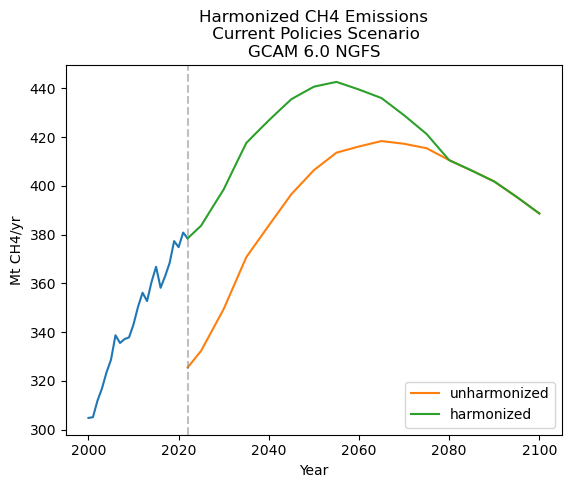

In [28]:
plt.plot(np.arange(2000, 2023), ch4_hist)
plt.plot(np.arange(2022, 2101), ch4_raw, label='unharmonized')
plt.plot(np.arange(2022, 2101), ch4_harm, label='harmonized')
plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Mt CH4/yr')
plt.title('Harmonized CH4 Emissions\n Current Policies Scenario\n'+mdl)
plt.legend()
plt.show()

In [29]:
n2o_hist = hist.loc[hist.Variable == 'Emissions|N2O'].values[0][255:]
n2o_raw = future.loc[future.Variable == 'Emissions|N2O'].loc[future.Scenario == 'Current Policies'].values[0][7:]
n2o_harm = scenarios_harmonised.loc[scenarios_harmonised.variable == 'Emissions|N2O'].loc[scenarios_harmonised.scenario == 'Current Policies'].values[0][5:]

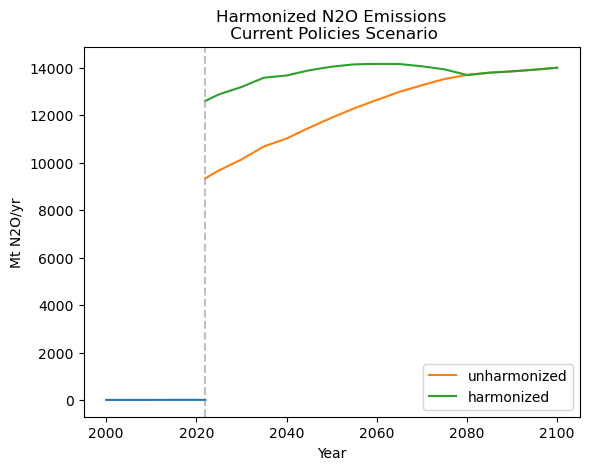

In [30]:
plt.plot(np.arange(2000, 2023), n2o_hist)
plt.plot(np.arange(2022, 2101), n2o_raw, label='unharmonized')
plt.plot(np.arange(2022, 2101), n2o_harm, label='harmonized')
plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Mt N2O/yr')
plt.title('Harmonized N2O Emissions\n Current Policies Scenario')
plt.legend()
plt.show()

In [31]:
def plot_harm(var, scen):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = scenarios_harmonised.loc[scenarios_harmonised.variable == 'Emissions|'+var].loc[scenarios_harmonised.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    
    plt.plot(np.arange(2000, 2023), histt)
    plt.plot(np.arange(2022, 2101), raw, label='unharmonized')
    plt.plot(np.arange(2022, 2101), harm, label='harmonized')
    plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel(unit)
    plt.title('Harmonized '+var+' Emissions\n'+scen+' Scenario\n'+mdl)
    plt.legend()
    plt.show()

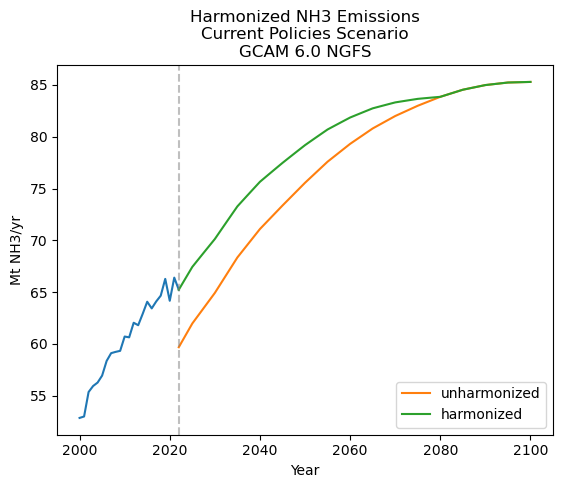

In [32]:
plot_harm('NH3', 'Current Policies')

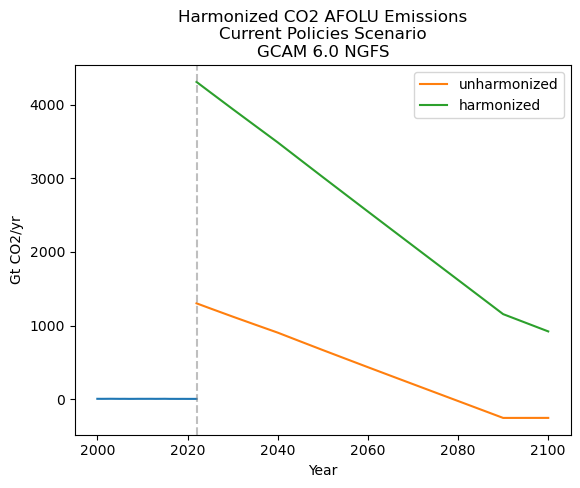

In [33]:
plot_harm('CO2 AFOLU', 'Current Policies')

In [34]:
row2change = future.loc[future.Variable == 'Emissions|CO2 FFI'].loc[future.Scenario == 'Current Policies']
row2change

,Model,Scenario,Region,Variable,Unit,2020,2021,2022,2023,2024,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
21,GCAM 6.0 NGFS,Current Policies,World,Emissions|CO2 FFI,Mt CO2/yr,34691.05554,34938.820924,35186.586308,35434.351692,35682.117076,...,41280.395958,41194.889156,41109.382354,41023.875552,40938.36875,40813.330012,40688.291274,40563.252536,40438.213798,40313.17506


In [35]:
# need to change N2O from kt to Mt!
future.loc[future.Variable == 'Emissions|CO2 FFI'].loc[future.Scenario == 'Current Policies'][5:] = row2change[5:] / 1000
# future.iloc[41, 0] = 'Emissions|N2O'
# future.iloc[41, 1] = 'kt N2O/yr'

In [36]:
row2change

,Model,Scenario,Region,Variable,Unit,2020,2021,2022,2023,2024,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
21,GCAM 6.0 NGFS,Current Policies,World,Emissions|CO2 FFI,Mt CO2/yr,34691.05554,34938.820924,35186.586308,35434.351692,35682.117076,...,41280.395958,41194.889156,41109.382354,41023.875552,40938.36875,40813.330012,40688.291274,40563.252536,40438.213798,40313.17506


In [37]:
future.loc[future.Variable == 'Emissions|CO2 FFI'].loc[future.Scenario == 'Current Policies']

,Model,Scenario,Region,Variable,Unit,2020,2021,2022,2023,2024,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
21,GCAM 6.0 NGFS,Current Policies,World,Emissions|CO2 FFI,Mt CO2/yr,34691.05554,34938.820924,35186.586308,35434.351692,35682.117076,...,41280.395958,41194.889156,41109.382354,41023.875552,40938.36875,40813.330012,40688.291274,40563.252536,40438.213798,40313.17506


In [38]:
numeric_columns = future.columns[5:] 

# Select the row where 'variable' is 'CO2' and divide values in numeric columns by 1000
c1 = future['Variable'] == 'Emissions|CO2 FFI'
c2 = future['Variable'] == 'Emissions|CO2 AFOLU'
condition = (c1) or (c2)
future.loc[condition, numeric_columns] = future.loc[condition, numeric_columns] / 1000


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
future.loc[condition]